## M8-L2 Problem 2

Let's revisit the material phase prediction problem once again. You will use this problem to try multi-class classification in PyTorch. You will have to write code for a classification network and for training.

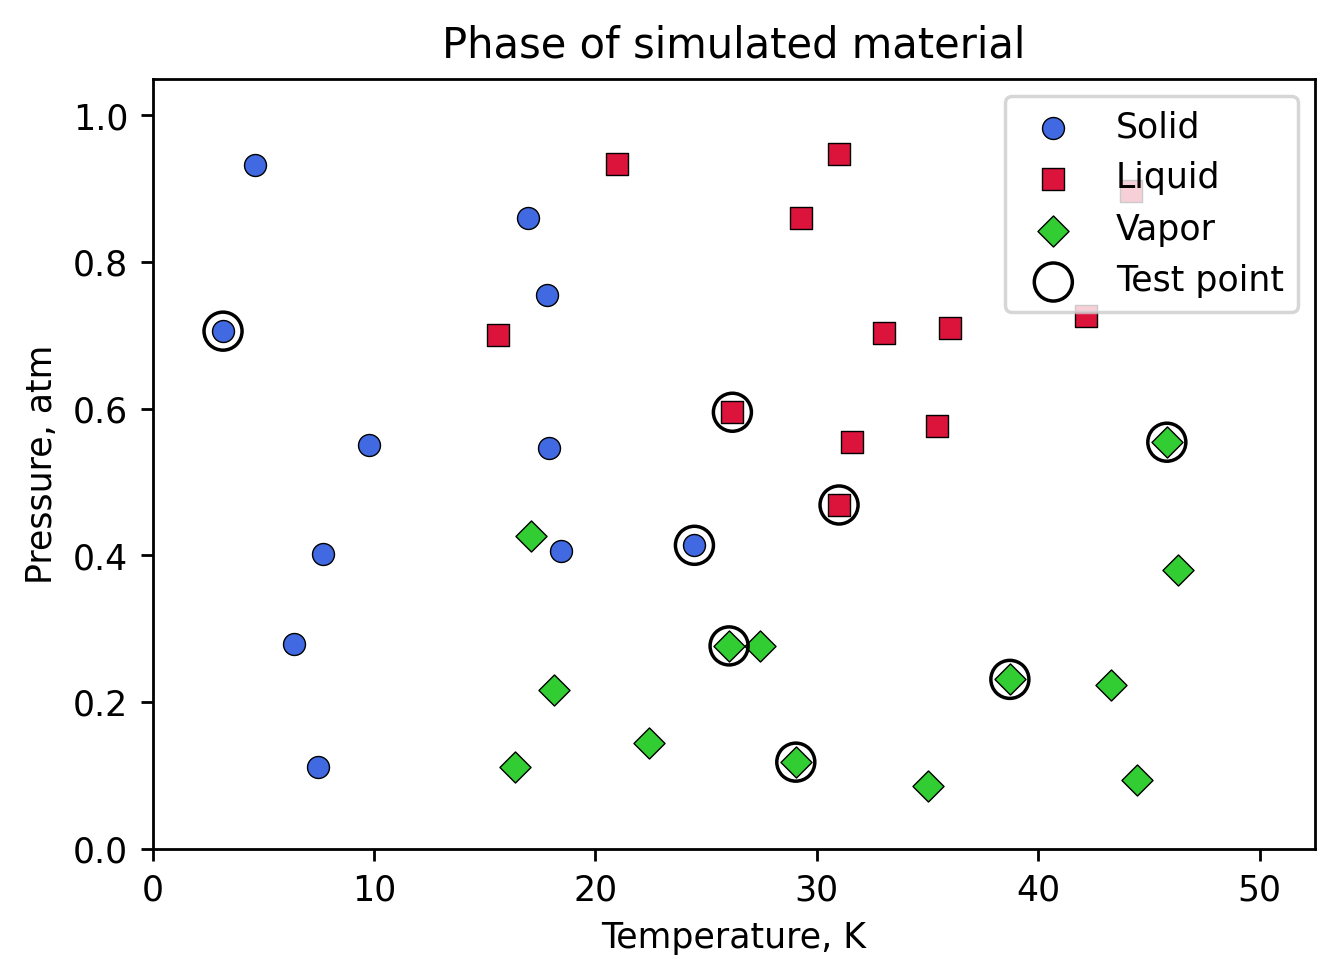

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch 
from torch import nn, optim

def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(4,2),dpi=250)
    plt.plot(train_loss,label="Training")
    plt.plot(val_loss,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def split_data(X, Y):
    np.random.seed(100)
    N = len(Y)
    train_mask = np.zeros(N, dtype=np.bool_)
    train_mask[np.random.permutation(N)[:int(N*0.8)]] = True
    train_x, val_x = torch.Tensor(X[train_mask,:]), torch.Tensor(X[np.logical_not(train_mask),:])
    train_y, val_y = torch.Tensor(Y[train_mask]), torch.Tensor(Y[np.logical_not(train_mask)])
    return train_x, val_x, train_y, val_y

x1 = np.array([7.4881350392732475,16.351893663724194,22.427633760716436,29.04883182996897,35.03654799338904,44.45894113066656,6.375872112626925,18.117730007820796,26.036627605010292,27.434415188257777,38.71725038082664,43.28894919752904,7.680445610939323,18.45596638292661,17.110360581978867,24.47129299701541,31.002183974403255,46.32619845547938,9.781567509498505,17.90012148246819,26.186183422327638,31.59158564216724,35.41479362252932,45.805291762864556,3.182744258689332,15.599210213275237,17.833532874090462,33.04668917049584,36.018483217500716,42.146619399905234,4.64555612104627,16.942336894342166,20.961503322165484,29.284339488686488,30.98789800436355,44.17635497075877,])
x2 = np.array([0.11120957227224215,0.1116933996874757,0.14437480785146242,0.11818202991034835,0.0859507900573786,0.09370319537993416,0.2797631195927265,0.216022547162927,0.27667667154456677,0.27706378696181594,0.2310382561073841,0.22289262976548535,0.40154283509241845,0.4063710770942623,0.427019677041788,0.41386015134623205,0.46883738380592266,0.38020448107480287,0.5508876756094834,0.5461309517884996,0.5953108325465398,0.5553291602539782,0.5766310772856306,0.5544425592001603,0.705896958364552,0.7010375141164304,0.7556329589465274,0.7038182951348614,0.7096582361680054,0.7268725170660963,0.9320993229847936,0.8597101275793062,0.9337944907498804,0.8596098407893963,0.9476459465013396,0.8968651201647702,])
X = np.vstack([x1,x2]).T
y = np.array([0,2,2,2,2,2,0,2,2,2,2,2,0,0,2,0,1,2,0,0,1,1,1,2,0,1,0,1,1,1,0,0,1,1,1,1,])

X = torch.Tensor(X)
Y = torch.tensor(y,dtype=torch.long)

train_x, val_x, train_y, val_y = split_data(X,Y)


def plot_data(newfig=True):
    xlim = [0,52.5]
    ylim = [0,1.05]
    markers = [dict(marker="o", color="royalblue"), dict(marker="s", color="crimson"), dict(marker="D", color="limegreen")]
    labels = ["Solid", "Liquid", "Vapor"]

    if newfig:
        plt.figure(figsize=(6,4),dpi=250)

    x = X.detach().numpy()
    y = Y.detach().numpy().flatten()

    for i in range(1+max(y)):
        plt.scatter(x[y==i,0], x[y==i,1], s=40, **(markers[i]), edgecolor="black", linewidths=0.4,label=labels[i])

    plt.scatter(val_x[:,0], val_x[:,1],s=120,c="None",marker="o",edgecolors="black",label="Test point")

    plt.title("Phase of simulated material")
    plt.legend(loc="upper right")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Temperature, K")
    plt.ylabel("Pressure, atm")
    plt.box(True)

def plot_model(model, res=200):
    xlim = [0,52.5]
    ylim = [0,1.05]
    xvals = np.linspace(*xlim,res)
    yvals = np.linspace(*ylim,res)
    x,y = np.meshgrid(xvals,yvals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
    XY = torch.Tensor(XY)
    color = model.predict(XY).reshape(res,res).detach().numpy()
    cmap = ListedColormap(["lightblue","lightcoral","palegreen"])
    plt.pcolor(x, y, color, shading="nearest", zorder=-1, cmap=cmap,vmin=0,vmax=2)
    return

plot_data()
plt.show()

## Model definition

In the cell below, complete the definition for `PhaseNet`, a classification neural network.

- The network should take in 2 inputs and return 3 outputs. 

- The network size and hidden layer activations are up to you.

- Make sure to use the proper activation function (for multi-class classification) at the final layer.

- The `predict()` method has been provided, to return the integer class value. You must finish `__init__()` and `forward()`.

In [43]:
class PhaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,3),
            nn.Softmax()
        )

    def predict(self,X):
        Y = self(X)
        return torch.argmax(Y,dim=1)

    def forward(self,X):
        return self.seq(X)

## Training

Most of the training code has been provided below. Please add the following where indicated:

- Define a loss function (for multiclass classification)

- Define an optimizer and call it `opt`. You may choose which optimizer.

Make sure the training curves you get are reasonable.

Epoch    0 of 1500:   Train Loss = 1.0978   Validation Loss = 1.0896
Epoch   60 of 1500:   Train Loss = 1.0309   Validation Loss = 1.0551
Epoch  120 of 1500:   Train Loss = 0.9077   Validation Loss = 0.9923
Epoch  180 of 1500:   Train Loss = 0.8485   Validation Loss = 0.9374
Epoch  240 of 1500:   Train Loss = 0.6795   Validation Loss = 0.7702
Epoch  300 of 1500:   Train Loss = 0.6417   Validation Loss = 0.7429
Epoch  360 of 1500:   Train Loss = 0.6319   Validation Loss = 0.7321
Epoch  420 of 1500:   Train Loss = 0.6281   Validation Loss = 0.7243
Epoch  480 of 1500:   Train Loss = 0.6261   Validation Loss = 0.7227
Epoch  540 of 1500:   Train Loss = 0.6251   Validation Loss = 0.7189
Epoch  600 of 1500:   Train Loss = 0.6244   Validation Loss = 0.7167
Epoch  660 of 1500:   Train Loss = 0.6240   Validation Loss = 0.7197
Epoch  720 of 1500:   Train Loss = 0.6237   Validation Loss = 0.7202
Epoch  780 of 1500:   Train Loss = 0.6236   Validation Loss = 0.7195
Epoch  840 of 1500:   Train Loss =

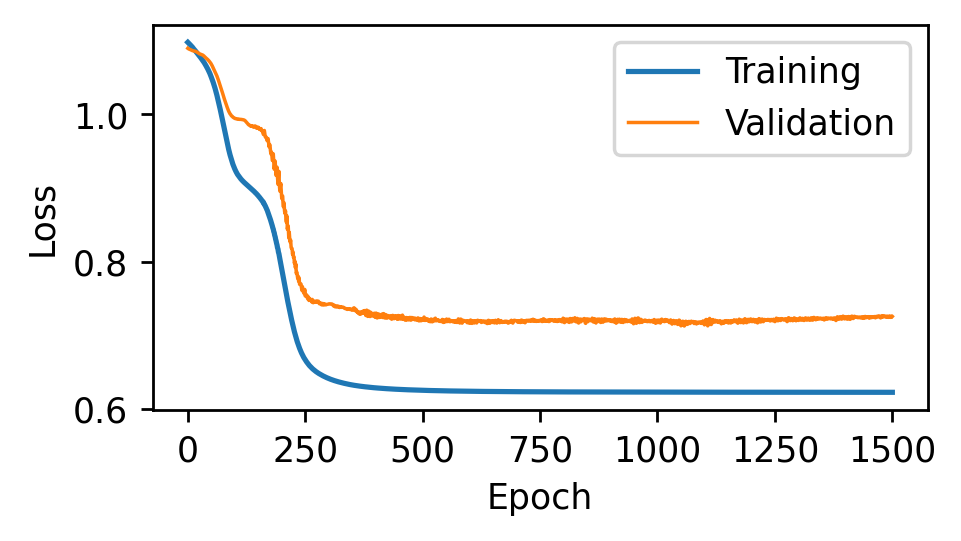

In [50]:
model = PhaseNet()

lr = 0.001
epochs = 1500

lossfun = nn.CrossEntropyLoss()

opt = optim.Adam(params = model.parameters(), lr=lr)

train_hist = []
val_hist = []

def getArray(index):
    arr = np.zeros(3)
    arr[index] = 1
    return arr
train_y_new = np.array([getArray(i) for i in train_y])
train_y_new = torch.Tensor(train_y_new)
val_y_new = np.array([getArray(i) for i in val_y])
val_y_new = torch.Tensor(val_y_new)

for epoch in range(epochs+1):
    model.train()
    loss_train = lossfun(model(train_x), train_y_new)
    train_hist.append(loss_train.item())

    model.eval()
    loss_val = lossfun(model(val_x), val_y_new)
    val_hist.append(loss_val.item())

    opt.zero_grad()
    loss_train.backward()
    opt.step()
    if epoch % int(epochs / 25) == 0:
        print(f"Epoch {epoch:>4} of {epochs}:   Train Loss = {loss_train.item():.4f}   Validation Loss = {loss_val.item():.4f}")


plot_loss(train_hist, val_hist)

## Plot results

Plot your network predictions with the data by running the following cell. If your network has significant overfitting/underfitting, go back and retrain a new network with different layer sizes/activations.

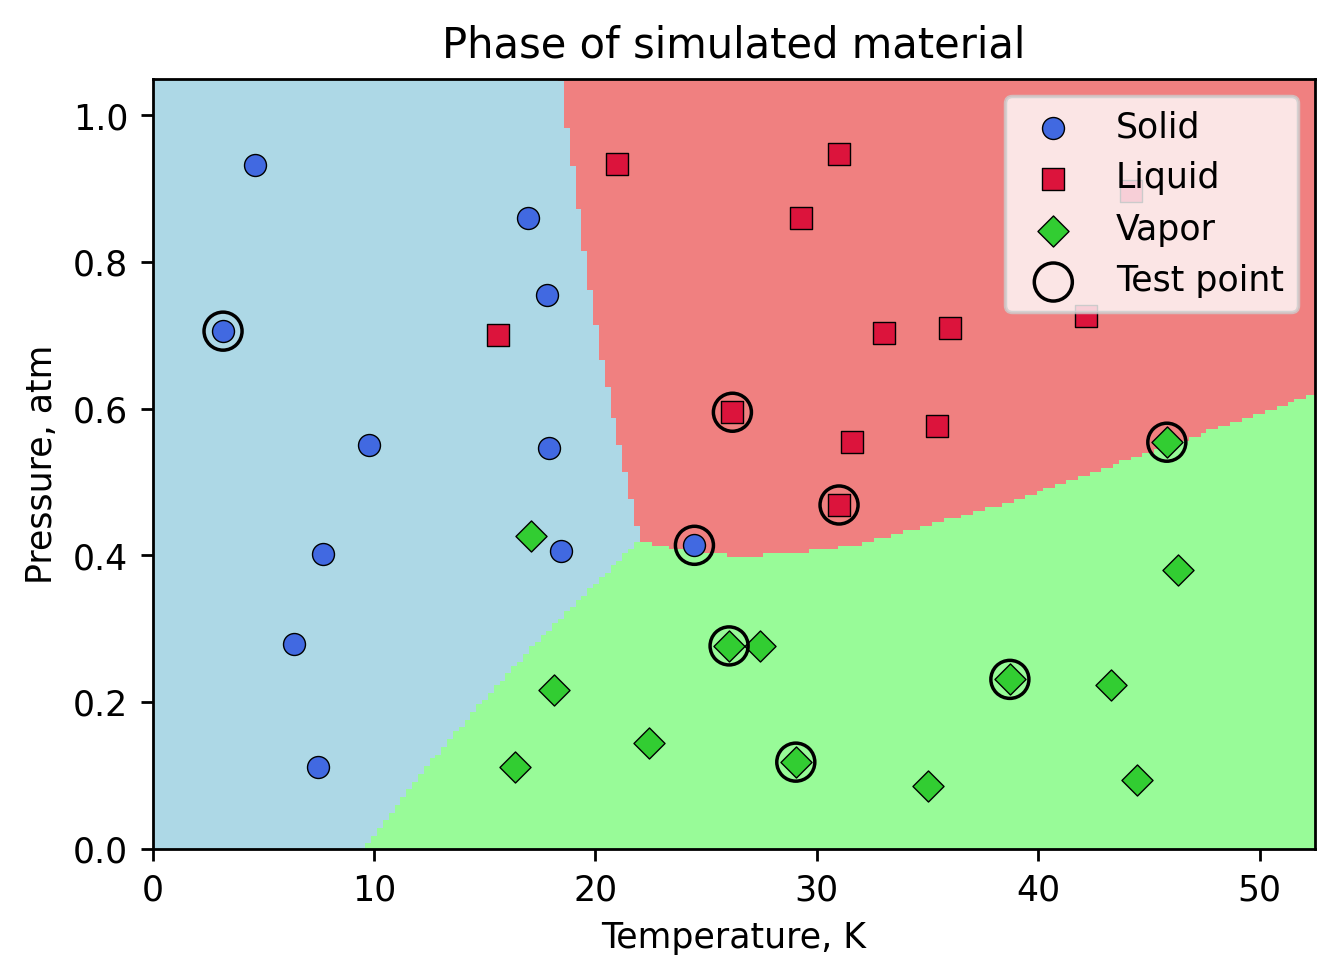

In [51]:
plot_data(newfig=True)
plot_model(model)
plt.show()